<a href="https://colab.research.google.com/github/MathieuGrosso/machine-learning-/blob/main/transfer_learning_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE, Isomap, MDS

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers.experimental import preprocessing
import cv2

from tensorflow.keras.utils import to_categorical


3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


#Load the data:

Choosing the dataset we will work on: we have two options. MNIST and Fashion-MNIST, set by the first variable of the following cell. 

We begin with MNIST. The variable "anomaly_class" indicates what images are considered as anomalous. we first test class 8 then class 9. 


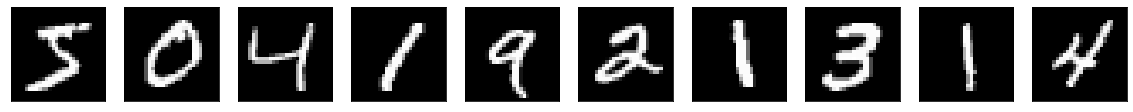

In [2]:
#import data of mnist and fashion mnist: 
dataset = "numbers" # "numbers" or "fashion"
anomaly_class = 8  # indicates which class is considered as anomalous

if dataset == "numbers":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    dico = {
            0: '0',
            1: '1',
            2: '2',
            3: '3',
            4: '4',
            5: '5',
            6: '6',
            7: '7',
            8: '8',
            9: '9',
    }
elif dataset =="fashion":
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    dico = {
            0: 'T-shirt/top',
            1: 'Trouser/pants',
            2: 'Pullover shirt',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot',
    }
else:
    print("Error: choices are 'fashion' or 'numbers'")

# We only keep normal images in the training set
#J'ai enlevé ces deux lignes pour le moment pour essayer de déjà faire marcher l'algo en version supervised
#x_train = x_train[y_train != anomaly_class]
#y_train = y_train[y_train != anomaly_class]

# Normalization and shape configuration
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Display some NORMAL images
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [3]:
print(x_train.shape, 'x train samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_test.shape, 'y test samples')


(60000, 28, 28, 1) x train samples
(10000, 28, 28, 1) x test samples
(60000,) y train samples
(10000,) y test samples


In [4]:
#one-hot encoding of classes

#define number of classes
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


print(x_train.shape, 'x train samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_test.shape, 'y test samples')


(60000, 28, 28, 1) x train samples
(10000, 28, 28, 1) x test samples
(60000, 10) y train samples
(10000, 10) y test samples


In [5]:
#adding a validation dataset: 
#used crossvalidation
...


# 2eme methode celle fait pour l'instant: 
val_nb = 5000 # number of validation samples
nb_samples = x_train.shape[0] #nb  samples en tout

if val_nb > nb_samples:
    raise ValueError("You need some samples to train your network!")
x_val = x_train[:val_nb, ]
x_train = x_train[val_nb:, ]
y_val = y_train[:val_nb]
y_train = y_train[val_nb:]

y_val = to_categorical(y_val, num_classes)

print(x_train.shape, 'x train samples')
print(y_train.shape, 'y train samples')
print(x_val.shape, 'x val samples')
print(y_val.shape, 'y val samples')
print(x_test.shape,'x test samples')
print(y_test.shape),'y test samples'


(55000, 28, 28, 1) x train samples
(55000, 10) y train samples
(5000, 28, 28, 1) x val samples
(5000, 10, 10) y val samples
(10000, 28, 28, 1) x test samples
(10000, 10)


(None, 'y test samples')

**Preprocessing of the data**

Modifions les données afin qu'elles soit adaptées au modèle, l'input shape doit etre: (,380,380,3)
On ne s'occupe plus des y puisque le modèle est unsupervised. On ne va donc modifier que x_train et x_test. 

In [6]:
#Reshape the data from grayscale to RGB

x_train_rgb, x_test_rgb,x_val_rgb = np.squeeze(x_train,axis=3), np.squeeze(x_test,axis=3),np.squeeze(x_val,axis=3) #(54149,28,28)
print(x_train_rgb.shape)
print(x_test_rgb.shape)
print(x_val_rgb.shape)



(55000, 28, 28)
(10000, 28, 28)
(5000, 28, 28)


In [7]:
#Repeat the image array 3 times on a new dimension 
x_train_rgb, x_test_rgb,x_val_rgb = np.repeat(x_train_rgb[..., np.newaxis], 3, -1), np.repeat(x_test_rgb[..., np.newaxis], 3, -1), np.repeat(x_val_rgb[..., np.newaxis], 3, -1)


In [8]:
print(x_train_rgb.shape)
print(x_test_rgb.shape)
print(x_val_rgb.shape)



(55000, 28, 28, 3)
(10000, 28, 28, 3)
(5000, 28, 28, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

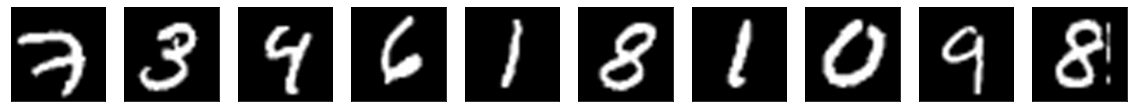

In [9]:
import cv2
import numpy as np
IMG_SIZE=380
#n=x_train_rgb.shape[0]
n=1000
image=[]
for i in range(n):
  new_image = cv2.resize(x_train_rgb[i], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
  image.append(new_image)
  x_train_array=np.array(image)

plt.figure(figsize=(20, 4))
m=10
for i in range(m):
    # display original
    ax = plt.subplot(1, m, i + 1)
    plt.imshow(x_train_array[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()





In [10]:
y_train_array=y_train[:n, ]
print(y_train_array.shape)

(1000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

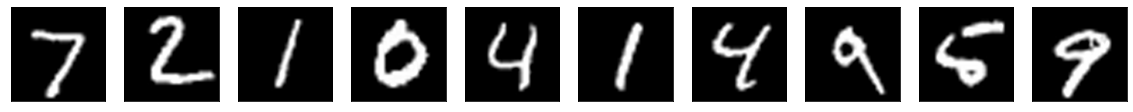

In [11]:
import cv2
import numpy as np


#n=x_test_rgb.shape[0]
n=250
image_test=[]
for i in range(n):
  new_image_test = cv2.resize(x_test_rgb[i], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
  image_test.append(new_image_test)
  x_test_array=np.array(image_test)

plt.figure(figsize=(20, 4))
m=10
for i in range(m):
    # display original
    ax = plt.subplot(1, m, i + 1)
    plt.imshow(x_test_array[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(100, 380, 380, 3)


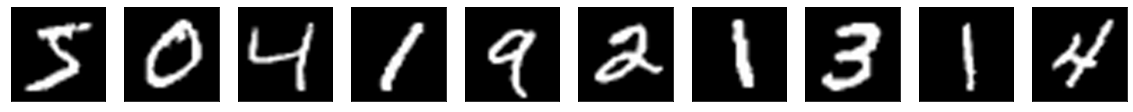

In [12]:
import cv2
import numpy as np


#n=x_val_rgb.shape[0]
n=100
image_test=[]
for i in range(n):
  new_image_test = cv2.resize(x_val_rgb[i], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
  image_test.append(new_image_test)
  x_val_array=np.array(image_test)

plt.figure(figsize=(20, 4))
m=10
for i in range(m):
    # display original
    ax = plt.subplot(1, m, i + 1)
    plt.imshow(x_val_array[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()

print(x_val_array.shape)

In [13]:
print(x_train_array.shape)
print(x_test_array.shape)
print(x_val_array.shape)



(1000, 380, 380, 3)
(250, 380, 380, 3)
(100, 380, 380, 3)


## Instanciate the model:

In [14]:
#loading the EfficientNet model: 
from tensorflow.keras.applications import EfficientNetB4
model = EfficientNetB4(weights='imagenet')

#remove the top layers
model = EfficientNetB4(include_top=False, weights='imagenet')

#summarize the model
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
____________________

In [15]:

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#model freezed: on fait du transfer learning avec ce modèle, les layers sont inchangées. 

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [16]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# Transfer learning and Fine Tuning:

**First step : transfer learning**

La première étape est de garder toute les layers freeze et de n'entrainer que les top layers. Pour se faire on prend un learning rate assez grand pour ne pas que l'entrainement soit trop long. 


Epoch 1/25
32/32 - 57s - loss: 2.5181 - accuracy: 0.1070
Epoch 2/25
32/32 - 13s - loss: 2.4386 - accuracy: 0.1040
Epoch 3/25
32/32 - 13s - loss: 2.4004 - accuracy: 0.1030
Epoch 4/25
32/32 - 13s - loss: 2.4207 - accuracy: 0.1060
Epoch 5/25
32/32 - 13s - loss: 2.4297 - accuracy: 0.0940
Epoch 6/25
32/32 - 13s - loss: 2.4065 - accuracy: 0.1020
Epoch 7/25
32/32 - 13s - loss: 2.3870 - accuracy: 0.1150
Epoch 8/25
32/32 - 13s - loss: 2.3590 - accuracy: 0.1310
Epoch 9/25
32/32 - 13s - loss: 2.4079 - accuracy: 0.1040
Epoch 10/25
32/32 - 13s - loss: 2.3892 - accuracy: 0.1060
Epoch 11/25
32/32 - 13s - loss: 2.4019 - accuracy: 0.1110
Epoch 12/25
32/32 - 13s - loss: 2.3750 - accuracy: 0.1070
Epoch 13/25
32/32 - 13s - loss: 2.4205 - accuracy: 0.0950
Epoch 14/25
32/32 - 13s - loss: 2.4032 - accuracy: 0.0880
Epoch 15/25
32/32 - 13s - loss: 2.3775 - accuracy: 0.1200
Epoch 16/25
32/32 - 13s - loss: 2.3835 - accuracy: 0.1140
Epoch 17/25
32/32 - 13s - loss: 2.3920 - accuracy: 0.1140
Epoch 18/25
32/32 - 13s

KeyError: ignored

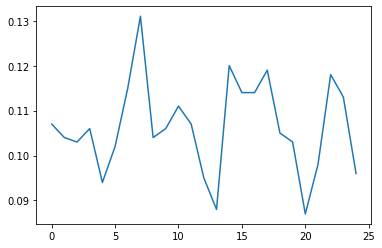

In [17]:
model = build_model(num_classes=num_classes)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(x_train_array, y_train_array, epochs=epochs, verbose=2)
plot_hist(hist)

**Second step: fine tuning**


La seconde étape va être d'unfreeze un certains nombre de couches et fitter le modèle en utilisant un learning rate plus petit. 
On va d'abord essayer d'unfreeze toutes les couches mais on aurait aussi pu le faire que sur certaines. 
Notre dataset étant très différent d'ImageNet (image en couleur pour ImageNet face à des dessins de chiffres en greyscale pour MNIST) cette étape est très important. En effet les features pré entrainé sont moins efficace et consiste en une grosse partie du travail. 
`(ajouter nos résultats ici pour voir si ça a bien marché: ...)`

Attention on ne modifie pas les batchnorm layers au risque de fortement réduire la performance. 


In [ ]:
#définir un modèle unfreeze pour le fine tuning: 

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 61  # @param {type: "slider", min:8, max:80}
hist = model.fit(x_train_array, y_train_array, epochs=epochs, verbose=2)
plot_hist(hist)

Epoch 1/61
32/32 - 23s - loss: 2.4294 - accuracy: 0.1050
Epoch 2/61
32/32 - 14s - loss: 2.4403 - accuracy: 0.0970
Epoch 3/61
32/32 - 14s - loss: 2.4450 - accuracy: 0.0940
Epoch 4/61
32/32 - 13s - loss: 2.3830 - accuracy: 0.1140
Epoch 5/61
32/32 - 13s - loss: 2.3805 - accuracy: 0.1060
Epoch 6/61
32/32 - 13s - loss: 2.4042 - accuracy: 0.1260
Epoch 7/61
32/32 - 13s - loss: 2.4020 - accuracy: 0.1090
Epoch 8/61
32/32 - 13s - loss: 2.4034 - accuracy: 0.1070
Epoch 9/61
32/32 - 13s - loss: 2.4260 - accuracy: 0.0940
Epoch 10/61
32/32 - 13s - loss: 2.3888 - accuracy: 0.1030
Epoch 11/61
32/32 - 13s - loss: 2.3914 - accuracy: 0.1090
Epoch 12/61
32/32 - 13s - loss: 2.3715 - accuracy: 0.1200
Epoch 13/61
32/32 - 13s - loss: 2.4052 - accuracy: 0.1010
Epoch 14/61
32/32 - 13s - loss: 2.3808 - accuracy: 0.1130
Epoch 15/61
32/32 - 13s - loss: 2.3843 - accuracy: 0.1000
Epoch 16/61
32/32 - 13s - loss: 2.4103 - accuracy: 0.0920
Epoch 17/61
32/32 - 13s - loss: 2.3924 - accuracy: 0.0940
Epoch 18/61
32/32 - 13s